# Analysis, detection & mitigation of felonious wallet accounts over the Ethereum blockchain network using machine learning techniques

|BITS ID No.| Name of Student|Email | Mobile
|-----------|------------------|---|--|
|2019HC04178 | Anjali Sunder Naik|sundernaik.anjali@in.bosch.com|8147757114|

## Import Libraries/Dataset (0 mark)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
#constants
invalid_data_path = '../data/invalid/invalid.csv'
verified_open_source_license_data_path = '../data/valid/export-verified-contractaddress-opensource-license.csv'
valid_data_path = '../data/valid/valid.csv'
verified_data_path = '../data/valid/verified-audited.csv'

## Data Visualization

Total number of felonious accounts in the dataset:  6297


<AxesSubplot:title={'center':'Felonious Ethereum Accounts data'}>

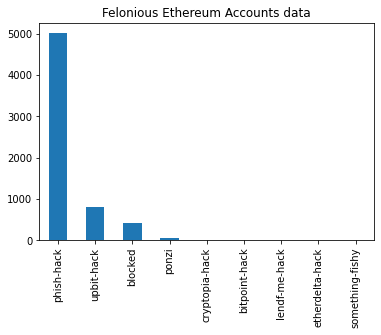

In [44]:
df = pd.read_csv(invalid_data_path)
print("Total number of felonious accounts in the dataset: ",df.shape[0])
plt.title("Felonious Ethereum Accounts data")
df['label'].value_counts().plot(kind='bar')

In [45]:
df = pd.read_csv(verified_open_source_license_data_path)
print("Total number of verified accounts in the dataset with open source license: ",df.shape[0])

Total number of verified accounts in the dataset with open source license:  5000


Total number of audited Ethereum accounts in the dataset:  941


<AxesSubplot:title={'center':'Audited Ethereum Accounts data'}, xlabel='Average Pulse', ylabel='Calorie Burnage'>

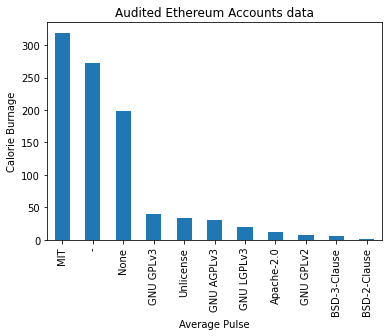

In [50]:
df = pd.read_csv(verified_data_path)
print("Total number of audited Ethereum accounts in the dataset: ",df.shape[0])
plt.title("Audited Ethereum Accounts data")
plt.xlabel("License")
plt.ylabel("Number of Ethereum Accounts")
df['License'].value_counts().plot(kind='bar')